In [1]:
# importing needed packages and setting up workspace
import numpy as np 
import pandas as pd 

import seaborn as sns

import pandas_profiling as pp
import math 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


plt.style.use('seaborn-colorblind')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# same as train except not given survived column
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
print(train_data.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [7]:
print(test_data.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Age has some missing values in both data sets, Embarked has 2 in the train data, Fare has 1 in the test data, Cabin has so many missing values it wouldnt make sense to impute so will drop.

In [8]:
train_data = train_data.drop(columns=['Cabin'])
test_data = test_data.drop(columns=['Cabin'])
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

## Survival Rate
Lets see what percentage of passengers survive

0    0.616162
1    0.383838
Name: Survived, dtype: float64


Text(0.5, 1.0, 'Survivors vs dead count')

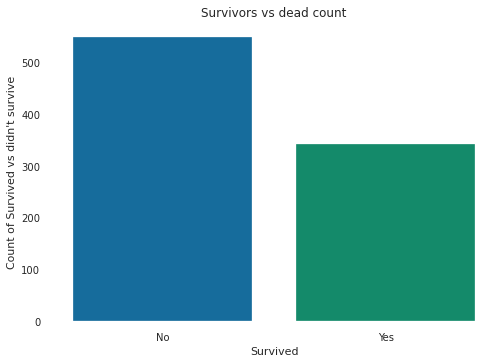

In [9]:
print(train_data['Survived'].value_counts(normalize=True))
g = sns.countplot(x=train_data['Survived'])

g.set_xticklabels(['No', 'Yes'])
plt.xlabel("Survived")
plt.ylabel("Count of Survived vs didn't survive")
plt.title("Survivors vs dead count")


38% of all passengers survive

### Feature analysis and Feature engineering

### Gender
We see that around 65% of the passengers were male while the remaining 35% were female.
However the survival rate for women was 74% versus males survival rate of 19%, so women were four times more likely to survive. We can see that sex will probably be a good predictor of survival.

In [10]:
train_data['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [11]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [12]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


Text(0.5, 1.0, 'Percentage of Survivors by Gender')

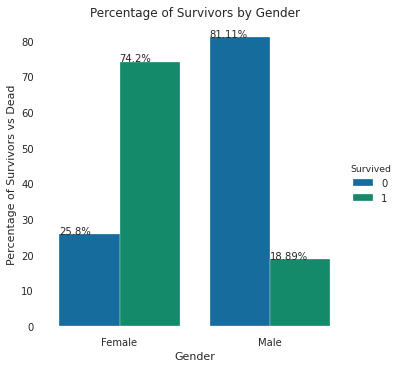

In [13]:
x, y = 'Sex', 'Survived'

g = (train_data
    .groupby(x)[y]
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent_survived')
    .reset_index()
    .pipe((sns.catplot, 'data'), x=x, y='percent_survived', hue=y, kind='bar'))

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x, txt_y, txt)
    
g.set_xticklabels(['Female', 'Male'])
plt.xlabel("Gender")
plt.ylabel("Percentage of Survivors vs Dead")
plt.title("Percentage of Survivors by Gender")


## Age 
Some missing value that will need to be dealt with.  
Average age of around 30.  
High amount of young passengers.  
Doesn't seem to be a relationship between age and survival.  

In [14]:
train_data['Age'].isna().sum()

177

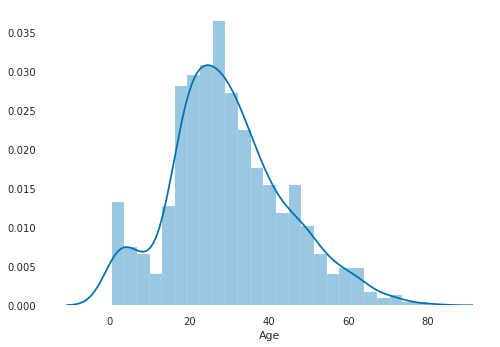

In [15]:
sns.distplot(train_data['Age'], bins=25)

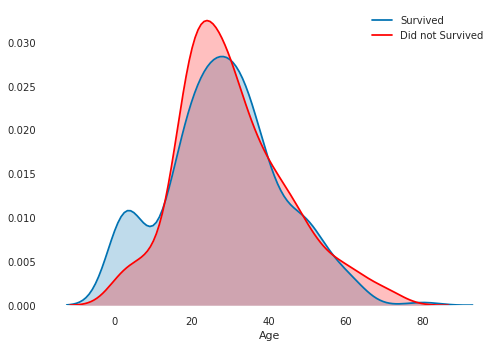

In [16]:
g = sns.kdeplot(train_data['Age'].loc[train_data['Survived'] == 1], 
                shade= True, label='Survived').set_xlabel('Age')
g = sns.kdeplot(train_data['Age'].loc[train_data['Survived'] == 0], 
                shade=True, color='r', label='Did not Survived')

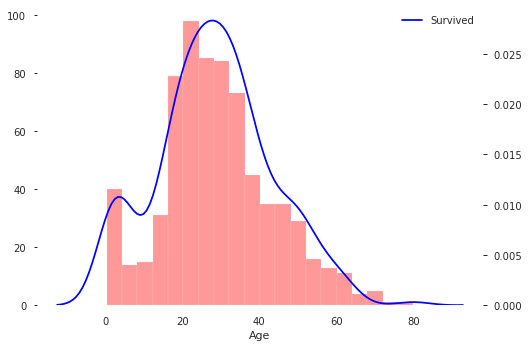

In [17]:
x1 = train_data.loc[train_data.Survived==1, 'Age']

fig, ax = plt.subplots()
ax=sns.distplot(train_data['Age'], ax=ax, kde=False, color='r')

ax2=ax.twinx()
ax2 = sns.distplot(x1, ax=ax2, color='b', hist=False, label = 'Survived')


plt.show()

## Pclass
Ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd   
Three classes on the ship, the majority in third class, 55%,  the number of passengers in the third class was higher than the number of passengers in the first and second classes combined.  

However, those in first class were most likely to survive, 63% of first class passengers survived,   47% of second class and only 24% of 3rd class survived.  

The difference in survival rates between classes tells us this will probably be a significant predictor of survival.  

Also there is a relationship between gender, class and survival.   
97% of first class females survived, 92% of second class females and then a significant drop to 50% survivors of third class women.    
37% of first class men survived, then 16% and 14% for second and thirs class respectively.   

In [18]:
print(train_data['Pclass'].value_counts(normalize=True))
print(train_data.groupby('Pclass')['Survived'].value_counts(normalize=True, dropna=False))

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64
Pclass  Survived
1       1           0.629630
        0           0.370370
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: Survived, dtype: float64


Text(0.5, 1.0, 'Percentage of Survivors by Class')

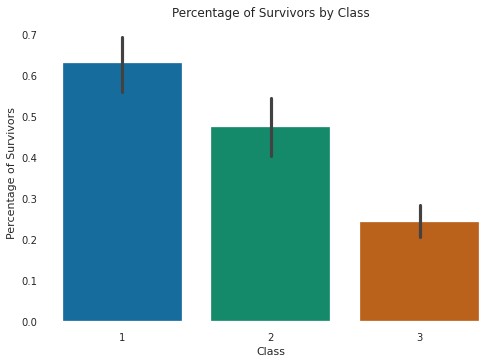

In [19]:
g = sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.xlabel("Class")
plt.ylabel("Percentage of Survivors")
plt.title("Percentage of Survivors by Class")

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

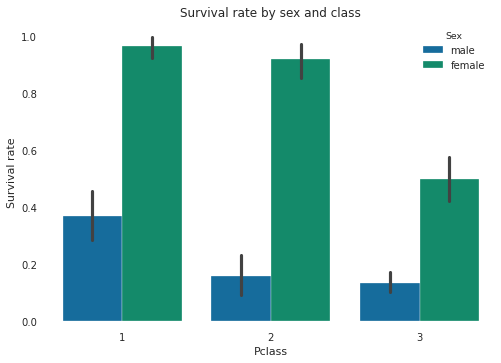

In [20]:
plt.title('Survival rate by sex and class')
g = sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train_data).set_ylabel('Survival rate')
train_data.groupby(['Pclass', 'Sex']).Survived.mean()

## Fare 
Mean of 32.2, median of 14.5, min of 0 (?), max of 512, high standard deviation, this all indicates high outliers.  
One fare of 500, next highest is a bit less than 300.  
The majority of fares are 0-50.  

Survival seems higher for higher fares.  

Bucketed fare due to differences.  
'Low', 'Mid', 'High', 'Very high' - majority of passengers in low fare category, only first class in High amd Very  high category as expected.  
Survival seemed to increase as fare increased then dropped slightly for the very high category.  

Zero fare?  
Includes passengers in 1st, 2nd and 3rd class.  
Seems like missing values rather than a fare of zero.  
Replaced zeros with nans which will be imputed during modelling.  

In [21]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

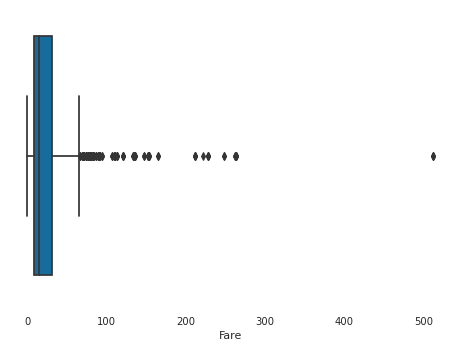

In [22]:
sns.boxplot(train_data['Fare'])

Text(0.5, 1.0, 'Fare distribution')

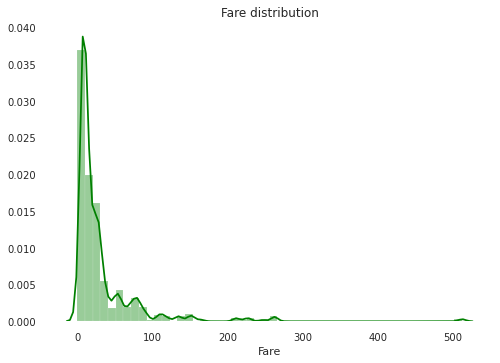

In [23]:
sns.distplot(train_data.Fare, color='g').set_title('Fare distribution')

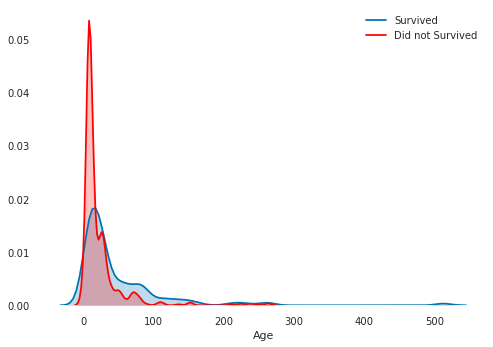

In [24]:
g = sns.kdeplot(train_data['Fare'].loc[train_data['Survived'] == 1], 
                shade= True, label='Survived').set_xlabel('Age')
g = sns.kdeplot(train_data['Fare'].loc[train_data['Survived'] == 0], 
                shade=True, color='r', label='Did not Survived')

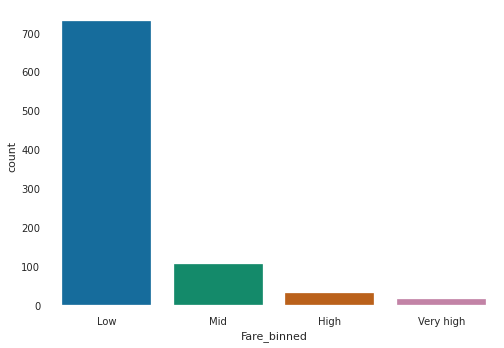

In [25]:
# Bucketing Fare
bins = [-1, 50, 100, 200, 501]
labels = ['Low', 'Mid', 'High', 'Very high']
train_data['Fare_binned'] = pd.cut(train_data['Fare'], bins=bins, labels=labels)
test_data['Fare_binned'] = pd.cut(test_data['Fare'], bins=bins, labels=labels)

sns.countplot(x='Fare_binned', data=train_data)

Text(0.5, 1.0, 'Percentage of Survivors by Fare amount')

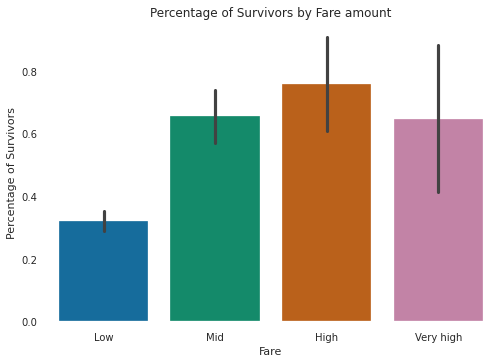

In [26]:
g = sns.barplot(x='Fare_binned', y='Survived', data=train_data)
plt.xlabel("Fare")
plt.ylabel("Percentage of Survivors")
plt.title("Percentage of Survivors by Fare amount")

Text(0.5, 0, 'Class')

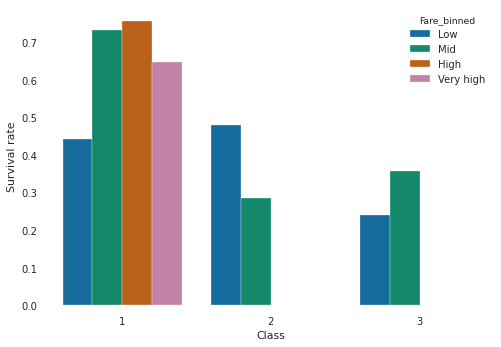

In [27]:
g = sns.barplot(x='Pclass', y='Survived', hue='Fare_binned', data=train_data, ci=None)
g.set_ylabel('Survival rate')
g.set_xlabel('Class')

In [28]:
# Investigating zero fare
train_data.loc[train_data['Fare']==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Fare_binned
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,S,Low
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,S,Low
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,S,Low
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,S,Low
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,S,Low
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,S,Low
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,S,Low
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,S,Low
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,S,Low
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,S,Low


In [29]:
# replacing zeros with nans which will be imputed later
train_data.loc[train_data['Fare'] == 0,'Fare'] = np.nan
# Checking it worked
train_data.loc[train_data['Fare']==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Fare_binned


## Embarked	
Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton  
The majority, 72% embarked from Southampton but only 34% of those that embarked from Southampton survived.  55% of those that embarked from Cherbourg survived, 39% of those that embarked from Queenstown survived.  
Point of embarkment has no logical reason to be related to survival so it could be a relationship between embarking point and class, which is confirmed by the visual below.    

The majority of those that embarked from Queenstown were in third class.  
Cherbourg is the only embarking point that had more first class passengers than any other class which would explain why it had the highest proportion of survivors.   


In [30]:
print(train_data["Embarked"].value_counts(normalize=True))
print(train_data.groupby("Embarked")['Survived'].value_counts(normalize=True))

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64
Embarked  Survived
C         1           0.553571
          0           0.446429
Q         0           0.610390
          1           0.389610
S         0           0.663043
          1           0.336957
Name: Survived, dtype: float64


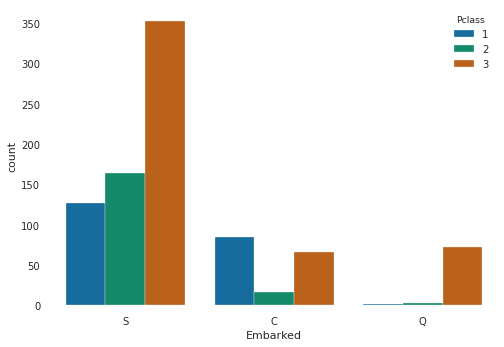

In [31]:
g = sns.countplot(data=train_data, x='Embarked', hue='Pclass')

## Name 
Could extract titles, Mr, Master etc.  
Definitely related to sex.  
Probably related to class and also age.    

In [32]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Fare_binned'],
      dtype='object')

## Dealing with missing values

In [33]:
y = train_data['Survived']
features = ['Fare', 'Fare_binned', 'Age', 'Pclass', 'Embarked', 'Sex']
X = train_data[features]

numerical_cols = ['Fare', 'Age']
categorical_cols = ['Pclass', 'Embarked', 'Fare_binned', 'Sex']

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Bundle preprocessing and modeling code 
titanic_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', RandomForestClassifier(n_estimators=100, 
                                                                    max_depth=5, random_state=1))
                                  ])

# Preprocessing of training data, fit model 
titanic_pipeline.fit(X,y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

Cross validation score: 0.820


In [34]:
X_test = test_data[features]
X_test.head()
predictions = titanic_pipeline.predict(X_test)

In [35]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
